In [1]:
from utils import set_root, PhysioLoader

set_root()

/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Current working directory: /home/guido/github/dev/physioex


In [2]:
# importing
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [3]:
models = ["seqecgnet"]
dataset = {"name": "mitdb", "version": None}
seqlen = 21
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
if dataset["name"] == "mitdb":
    sleep_stages = ["N", "S", "V", "F", "Q"]

labels_idx = np.arange(len(sleep_stages)).astype(int)

100%|██████████| 507/507 [00:02<00:00, 179.02it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 341.14it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 271.39it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 345.06it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 337.24it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 344.56it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 285.45it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 312.78it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 330.87it/s]


(340557,) (340557,)


100%|██████████| 507/507 [00:01<00:00, 312.85it/s]


(340557,) (340557,)
Accuracy: 83.26% +/- 2.53%


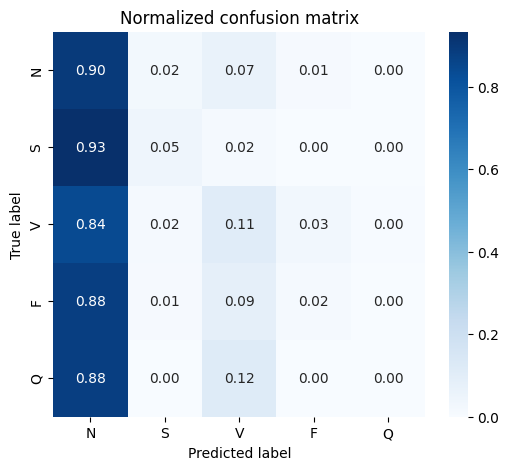

In [4]:
for model in models:

    if dataset["version"] is None:
        ckp_path = f"models/cel/{model}/seqlen={seqlen}/{dataset['name']}"
    else:
        ckp_path = (
            f"models/cel/{model}/seqlen={seqlen}/{dataset['name']}/{dataset['version']}"
        )

    loader = PhysioLoader(
        model_name=model,
        loss_name=loss,
        ckp_path=ckp_path,
        dataset_name=dataset["name"],
        version=dataset["version"],
        use_cache=True,
        sequence_lenght=seqlen,
        batch_size=batch_size,
    )

    acc = []
    cm = []
    reports = []

    for i in range(len(loader.checkpoints)):
        model, _, _, test_loader = loader.get_fold(i)
        y_pred = []
        y_true = []

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Imposta il modello in modalità di valutazione
        model = model.eval().to(device)

        outputs = []
        y_true = []
        # Disabilita il calcolo del gradiente
        with torch.no_grad():
            # Aggiungi tqdm per mostrare il progresso
            for inputs, labels in tqdm(test_loader):
                # Calcola le previsioni del modello
                outputs.extend(model(inputs.to(device)).cpu().detach())
                y_true.extend(labels.cpu().detach())

        outputs = torch.stack(outputs)
        y_true = torch.stack(y_true)

        y_pred = torch.argmax(outputs, dim=len(outputs.size()) - 1)

        if len(y_pred.size()) == 2:
            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)

        y_true = y_true.numpy()
        y_pred = y_pred.numpy()

        print(y_true.shape, y_pred.shape)

        acc.append(accuracy_score(y_true, y_pred))
        cm.append(confusion_matrix(y_true, y_pred, labels=labels_idx))
        reports.append(classification_report(y_true, y_pred))

    acc = np.array(acc)
    cm = np.array(cm)

    print(f"Accuracy: {acc.mean() * 100:.2f}% +/- {acc.std() * 100:.2f}%")

    cm_mean = cm.mean(axis=0)

    cm_mean = cm_mean.astype("float") / cm_mean.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_mean,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=sleep_stages,
        yticklabels=sleep_stages,
    )
    plt.title("Normalized confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()